# libraries

In [1]:
# data processing
import pandas as pd
import numpy as np
import torch
from scipy import signal

# visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# data

In [2]:
fs = 200
n_channels = 65

In [3]:
data_Dinh = torch.load('data/data_Dinh_fs200.pt')
data_Heitmann = torch.load('data/data_Heitmann_fs200.pt')
eeg_data = torch.cat((data_Dinh, data_Heitmann))
eeg_data.shape

torch.Size([230, 65, 55000])

In [4]:
labels_Dinh = torch.load('data/labels_Dinh_fs200.pt')
labels_Heitmann = torch.load('data/labels_Heitmann_fs200.pt')
eeg_labels = torch.cat((labels_Dinh, labels_Heitmann))
eeg_labels.shape

torch.Size([230])

In [5]:
tabular_Dinh = pd.read_excel('data/tabular_Dinh.xlsx')
tabular_Dinh.rename({
    'Project prefix': 'class',
    'Label': 'label',
    'Age\n(years)': 'age',
    'Sex (m/f)': 'sex',
    'Pain duration\n(months)': 'pain_duration',
    'Avg. pain\nIntensity \n(0 – 10)': 'avg_pain_intensity',
    'Curr. Pain \nIntensity\n(0 – 10)': 'curr_pain_intensity',
}, axis=1, inplace=True)
tabular_Dinh.drop(['Subject ID'], axis=1, inplace=True)
tabular_Dinh.shape

(189, 13)

In [6]:
tabular_Dinh['class'].value_counts()

healthy              88
various              47
chronic_back_pain    34
Fibromyalgia         20
Name: class, dtype: int64

In [7]:
tabular_Heitmann = pd.read_excel('data/tabular_Heitmann.xlsx')
tabular_Heitmann.rename({
    'Project prefix': 'class',
    'Label': 'label',
    'Age (years)': 'age',
    'Sex (m/f)': 'sex',
    'Pain duration (month)': 'pain_duration',
    'Avg. pain intensity (0-10)': 'avg_pain_intensity',
    'Curr. pain intensity (0-10)': 'curr_pain_intensity',
}, axis=1, inplace=True)
tabular_Heitmann.drop(['Subject ID'], axis=1, inplace=True)
tabular_Heitmann.shape

(41, 13)

In [8]:
tabular_Heitmann['class'].value_counts()

chronic_back_pain    26
various              12
Fibromyalgia          3
Name: class, dtype: int64

In [9]:
df = pd.concat([tabular_Dinh, tabular_Heitmann], ignore_index=True)

In [10]:
df.sample(5)

,class,label,age,sex,pain_duration,avg_pain_intensity,curr_pain_intensity,BDI,PDQ,MQS,VR-12 PCS,VR-12 MCS,PDI
215,chronic_back_pain,1,58,f,240.0,6.0,NaN,8.0,NaN,2.3,NaN,NaN,2.57
128,Fibromyalgia,2,46,m,NaN,NaN,1.8,20.0,NaN,0.0,NaN,NaN,NaN
96,chronic_back_pain,1,65,f,132.0,3.0,3.0,5.0,24.0,5.9,NaN,NaN,NaN
40,healthy,0,53,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,Fibromyalgia,2,56,f,NaN,NaN,2.9,22.0,NaN,0.0,NaN,NaN,NaN


In [11]:
df['class'].value_counts()

healthy              88
chronic_back_pain    60
various              59
Fibromyalgia         23
Name: class, dtype: int64

In [12]:
healthy_idx = df[df['class']=='healthy'].index
chronic_back_pain_idx = df[df['class']=='chronic_back_pain'].index
various_idx = df[df['class']=='various'].index
fibromyalgia_idx = df[df['class']=='Fibromyalgia'].index
len(healthy_idx), len(chronic_back_pain_idx), len(various_idx), len(fibromyalgia_idx)

(88, 60, 59, 23)

In [13]:
healthy_eeg = eeg_data[healthy_idx].mean(dim=0)
chronic_back_pain_eeg = eeg_data[chronic_back_pain_idx].mean(dim=0)
various_eeg = eeg_data[various_idx].mean(dim=0)
fibromyalgia_eeg = eeg_data[fibromyalgia_idx].mean(dim=0)
healthy_eeg.shape,chronic_back_pain_eeg.shape,various_eeg.shape,fibromyalgia_eeg.shape

(torch.Size([65, 55000]),
 torch.Size([65, 55000]),
 torch.Size([65, 55000]),
 torch.Size([65, 55000]))

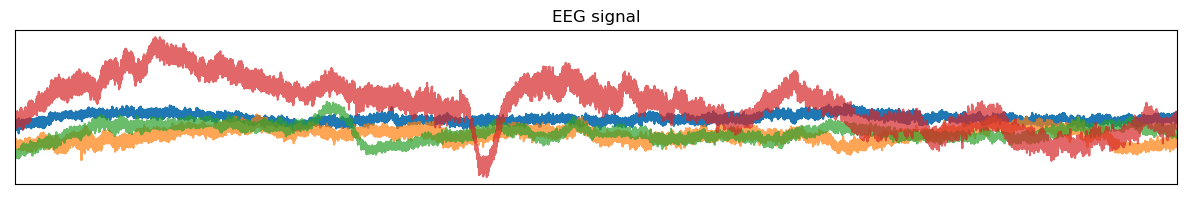

In [14]:
channel = 48
plt.figure(figsize=(15, 2))
plt.plot(healthy_eeg[channel])
plt.plot(chronic_back_pain_eeg[channel], alpha=0.7)
plt.plot(various_eeg[channel], alpha=0.7)
plt.plot(fibromyalgia_eeg[channel], alpha=0.7)
plt.yticks([], [])
plt.xticks([], [])
#plt.legend(['healthy', 'chronic_back_pain', 'various', 'fibromyalgia'], bbox_to_anchor=(0.4, 1))
plt.title("EEG signal")
plt.xlim(0,55000)
plt.show()

In [15]:
def plot_eeg_data(channels):
    assert isinstance(channels, list)
    total_channels = len(channels)
    fig, axs = plt.subplots(total_channels, sharex=True, figsize=(15, total_channels*1.1))
    if total_channels == 1:
        axs.plot(healthy_eeg[channels[0],:])
        axs.plot(chronic_back_pain_eeg[channels[0],:], alpha=0.7)
        axs.plot(various_eeg[channels[0],:], alpha=0.7)
        axs.plot(fibromyalgia_eeg[channels[0],:], alpha=0.7)
    else:
        for i in range(total_channels):
            axs[i].plot(healthy_eeg[channels[i],:])
            axs[i].plot(chronic_back_pain_eeg[channels[i],:], alpha=0.7)
            axs[i].plot(various_eeg[channels[i],:], alpha=0.7)
            axs[i].plot(fibromyalgia_eeg[channels[i],:], alpha=0.7)
            axs[i].set_ylabel(f'EEG {channels[i]}')
    #fig.savefig('channels.png')
    #fig.suptitle('Average - All channels', fontsize=16)

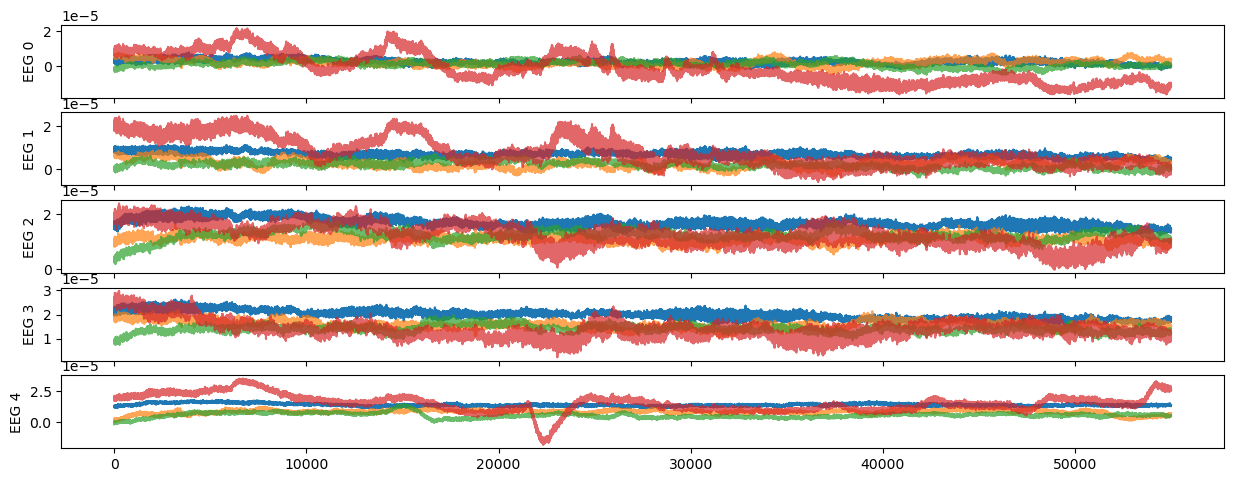

In [16]:
channels = list(range(5))
plot_eeg_data(channels)

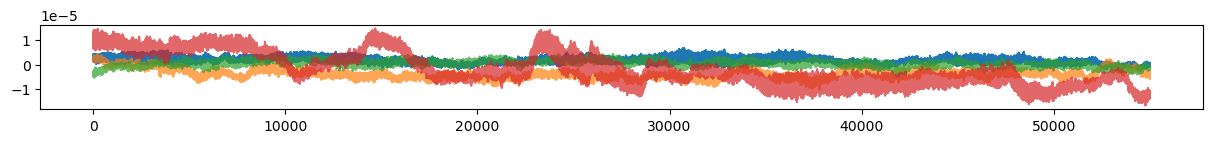

In [17]:
channels = [60]
plot_eeg_data(channels)

# psd

In [18]:
fs = 200

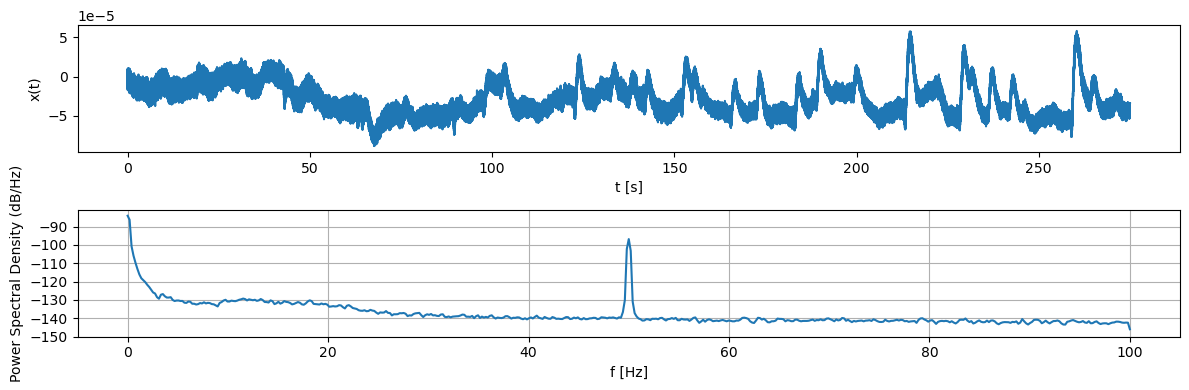

In [19]:
subject = 1
channel = 22
x_t = eeg_data[subject][channel]
N = len(x_t)
t = torch.arange(0, N) * 1/fs

plt.figure(figsize=(12, 4))

plt.subplot(211)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.psd(x_t, 1024, fs)
plt.xlabel('f [Hz]')

plt.tight_layout()
plt.show()

In [20]:
N = eeg_data.shape[-1]
t = torch.arange(0, N) * 1/fs

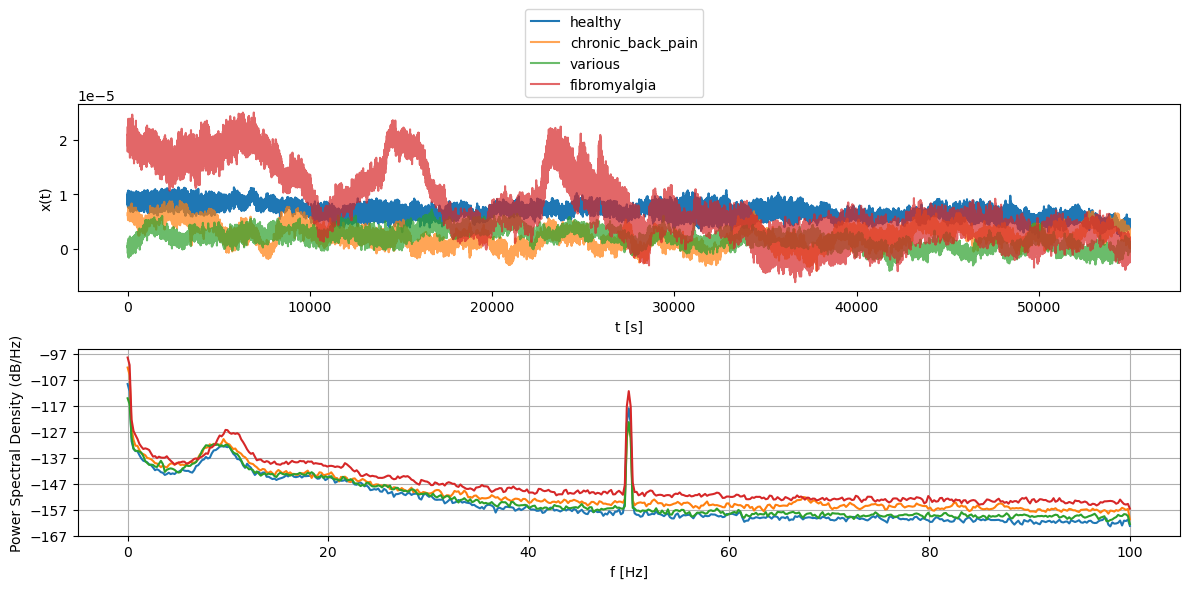

In [21]:
channel = 60

plt.figure(figsize=(12, 6))

plt.subplot(211)
plt.plot(healthy_eeg[1])
plt.plot(chronic_back_pain_eeg[1], alpha=0.7)
plt.plot(various_eeg[1], alpha=0.7)
plt.plot(fibromyalgia_eeg[1], alpha=0.7)
plt.legend(['healthy', 'chronic_back_pain', 'various', 'fibromyalgia'], bbox_to_anchor=(0.4, 1))
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.psd(healthy_eeg[channel], 1024, fs)
plt.psd(chronic_back_pain_eeg[channel], 1024, fs)
plt.psd(various_eeg[channel], 1024, fs)
plt.psd(fibromyalgia_eeg[channel], 1024, fs)
plt.xlabel('f [Hz]')

plt.tight_layout()
plt.show()

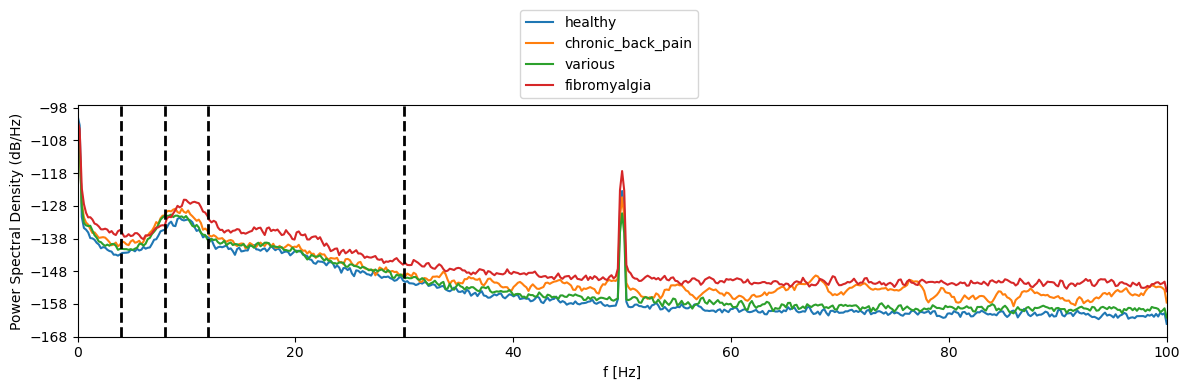

In [22]:
channel = 50

plt.figure(figsize=(12, 4))
plt.psd(healthy_eeg[channel], 1024, fs)
plt.psd(chronic_back_pain_eeg[channel], 1024, fs)
plt.psd(various_eeg[channel], 1024, fs)
plt.psd(fibromyalgia_eeg[channel], 1024, fs)
plt.xlabel('f [Hz]')

plt.axvline(x=4, linewidth=2, linestyle='dashed', color='black')
plt.axvline(x=8, linewidth=2, linestyle='dashed', color='black')
plt.axvline(x=12, linewidth=2, linestyle='dashed', color='black')
plt.axvline(x=30, linewidth=2, linestyle='dashed', color='black')

plt.axvspan(0, 4, alpha=0.2, color='white')
plt.axvspan(4, 8, alpha=0.2, color='white')
plt.axvspan(8, 12, alpha=0.2, color='white')
plt.axvspan(12, 30, alpha=0.2, color='white')
plt.axvspan(30, 100, alpha=0.2, color='white')

plt.legend(['healthy', 'chronic_back_pain', 'various', 'fibromyalgia'], bbox_to_anchor=(0.4, 1))
plt.xlim(0, 100)
plt.grid(False)
plt.tight_layout()
plt.show()

# spectrogram

x = time, y = freq, z = spectrum (decibels)

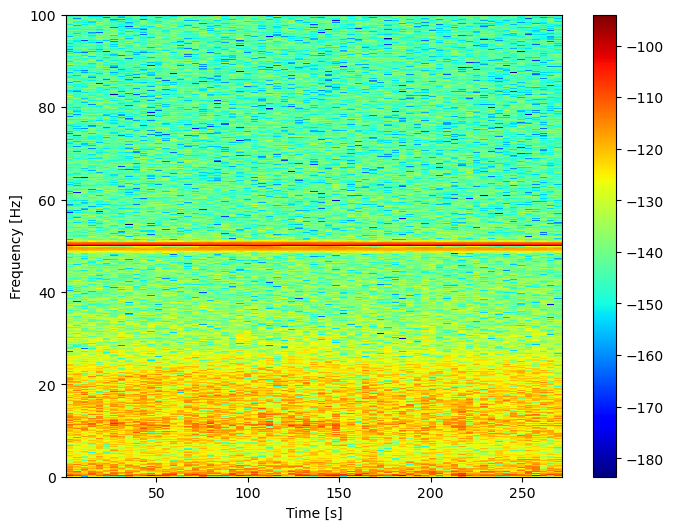

In [23]:
#https://mark-kramer.github.io/Case-Studies-Python/03.html
plt.figure(figsize=(8, 6))

interval = 1000 #5 s (200 * 5)
overlap = int(fs * 0.95)

# healthy - 0
# chronic_back_pain - 89
# various - 176
# fibromyalgia - 136
subject = 136
channel = 60
x_t = eeg_data[subject][channel]

#nperseg - the length of a segment
#noverlap - the number of samples to overlap,
f, t, Sxx = signal.spectrogram(x_t, fs=fs, nperseg=interval, noverlap=overlap)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')
plt.colorbar()                
plt.ylim([0, 100]) # frequency range,
plt.xlabel('Time [s]')         
plt.ylabel('Frequency [Hz]')
plt.show()

we observe a band of high power at 50 Hz that persists for all time.  
This corresponds to the 50 Hz line noise present for the entire duration of the recording

In [24]:
## mean amplitude per freq band
#https://dsp.stackexchange.com/questions/45345/how-to-correctly-compute-the-eeg-frequency-bands-with-python

## notch filter

In [25]:
import mne
mne.set_log_level('WARNING') # output less verbose

In [26]:
subject = 136
data = eeg_data[subject]
ch_types = ['eeg'] * n_channels
info = mne.create_info(n_channels, sfreq=fs, ch_types=ch_types)
patient_data = mne.io.RawArray(data=data, info=info)
patient_data

<RawArray | 65 x 55000 (275.0 s), ~27.3 MB, data loaded>

In [27]:
#patient_data.plot(n_channels=20)

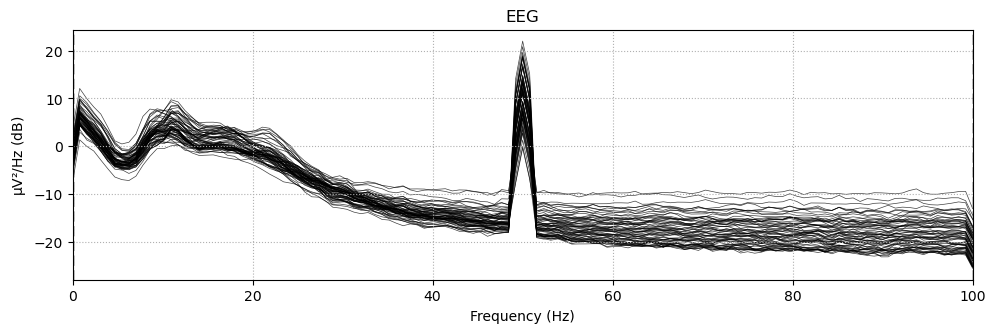

In [28]:
patient_data.compute_psd().plot()

In [29]:
patient_data.get_data().shape

(65, 55000)

In [30]:
modified = patient_data.copy()\
    .filter(l_freq=0.5, h_freq=None)\
    .notch_filter(freqs=50)
modified

<RawArray | 65 x 55000 (275.0 s), ~27.3 MB, data loaded>

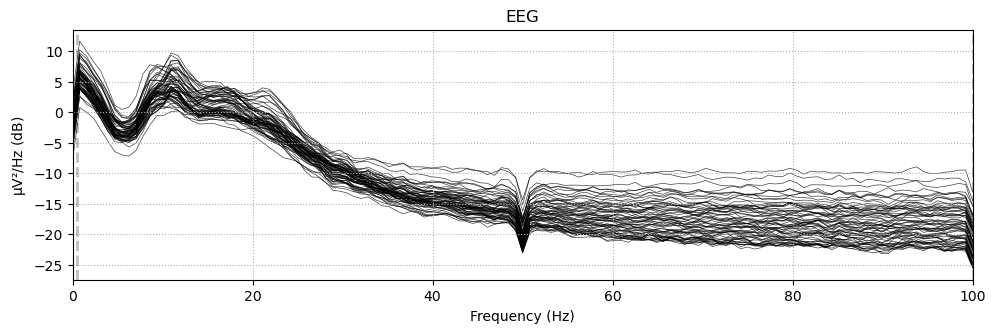

In [31]:
modified.compute_psd().plot()

In [32]:
modified.get_data().shape

(65, 55000)

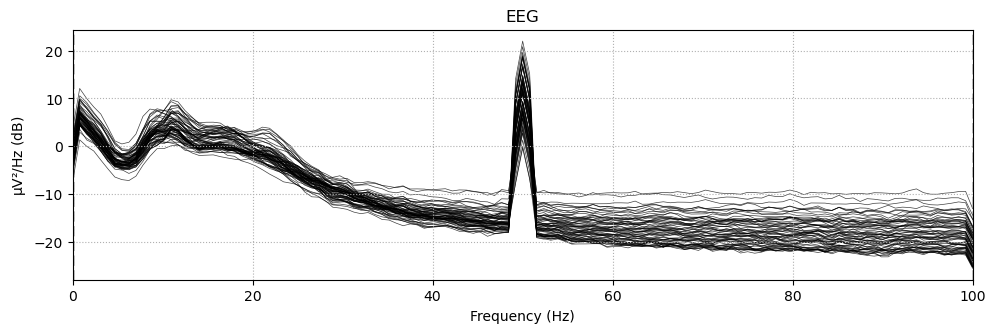

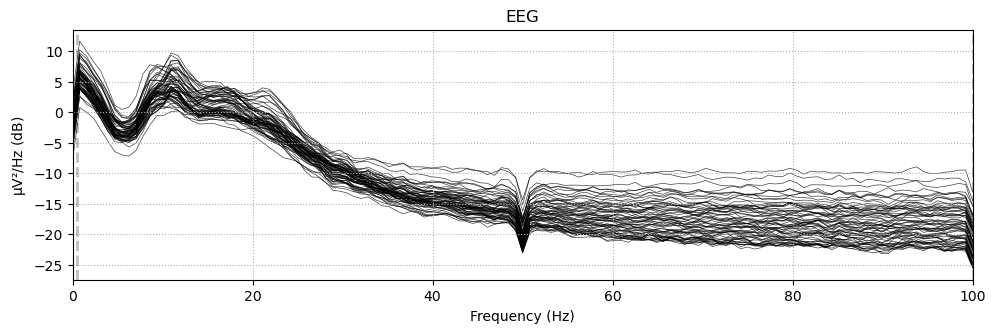

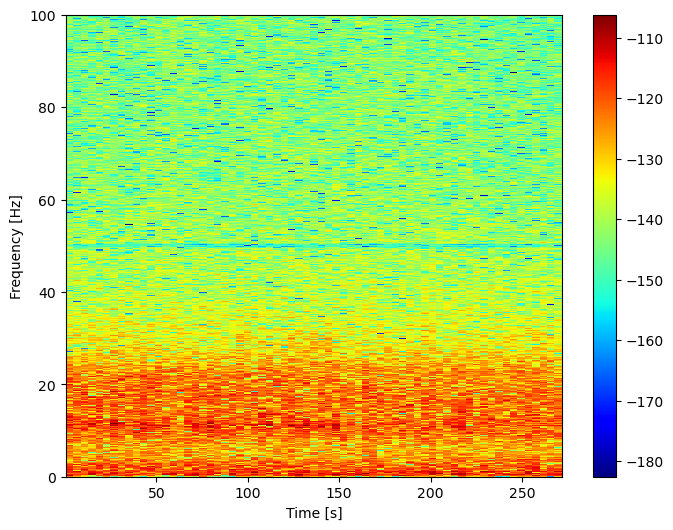

In [33]:
#https://mark-kramer.github.io/Case-Studies-Python/03.html
plt.figure(figsize=(8, 6))

interval = 1000 #10 s (200 * 10)
overlap = int(fs * 0.95)

# healthy - 0
# chronic_back_pain - 89
# various - 176
# fibromyalgia - 136
channel = 60
x_t = modified.get_data()[channel]

#nperseg - the length of a segment
#noverlap - the number of samples to overlap,
f, t, Sxx = signal.spectrogram(x_t, fs=fs, nperseg=interval, noverlap=overlap)

plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')
plt.colorbar()                
plt.ylim([0, 100]) # frequency range,
plt.xlabel('Time [s]')         
plt.ylabel('Frequency [Hz]')
plt.show()

In [34]:
patient_data.get_data().shape

(65, 55000)

# frequencies bands

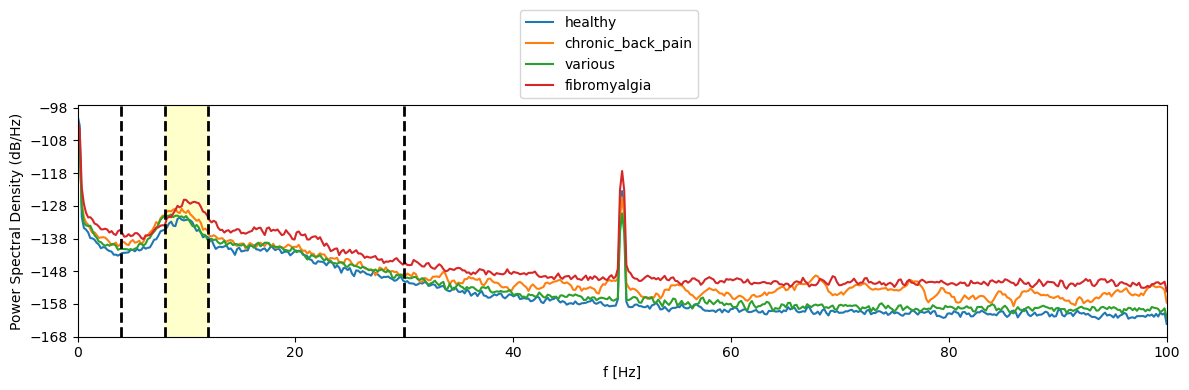

In [35]:
channel = 50

plt.figure(figsize=(12, 4))
plt.psd(healthy_eeg[channel], 1024, fs)
plt.psd(chronic_back_pain_eeg[channel], 1024, fs)
plt.psd(various_eeg[channel], 1024, fs)
plt.psd(fibromyalgia_eeg[channel], 1024, fs)
plt.xlabel('f [Hz]')

plt.axvline(x=4, linewidth=2, linestyle='dashed', color='black')
plt.axvline(x=8, linewidth=2, linestyle='dashed', color='black')
plt.axvline(x=12, linewidth=2, linestyle='dashed', color='black')
plt.axvline(x=30, linewidth=2, linestyle='dashed', color='black')

plt.axvspan(0, 4, alpha=0.2, color='white')
plt.axvspan(4, 8, alpha=0.2, color='white')
plt.axvspan(8, 12, alpha=0.2, color='yellow')
plt.axvspan(12, 30, alpha=0.2, color='white')
plt.axvspan(30, 100, alpha=0.2, color='white')

plt.legend(['healthy', 'chronic_back_pain', 'various', 'fibromyalgia'], bbox_to_anchor=(0.4, 1))
plt.xlim(0, 100)
plt.grid(False)
plt.tight_layout()
plt.show()

In [36]:
import mne
import numpy as np
import torch
import torch.fft as fft
from yasa import sliding_window

mne.set_log_level('WARNING')

def bandpass_filter(eeg_data, fs, freq_min, freq_max):
    """
    Apply bandpass filter to EEG data

    Parameters
    ----------
    eeg_data: [patients, channels, timepoints]
    fs: sampling frequency
    freq_min: minimum frequency
    freq_max: maximum frequency

    Returns
    -------
    EEG with bandpass filter applied
    """
    print(f"Applying bandpass filter with freq_min {freq_min} and freq_max {freq_max}...")
    nb_channels = eeg_data.shape[1]
    ch_types = ['eeg'] * nb_channels
    info = mne.create_info(nb_channels, sfreq=fs, ch_types=ch_types)
    all_patients = mne.EpochsArray(eeg_data, info)
    all_patients.filter(freq_min, freq_max)
    eeg_data = torch.tensor(np.array(all_patients.get_data(), dtype='float32'))
    return eeg_data

In [37]:
fs = 200
subject = 1
channel = 22
x_t = eeg_data[subject][channel]

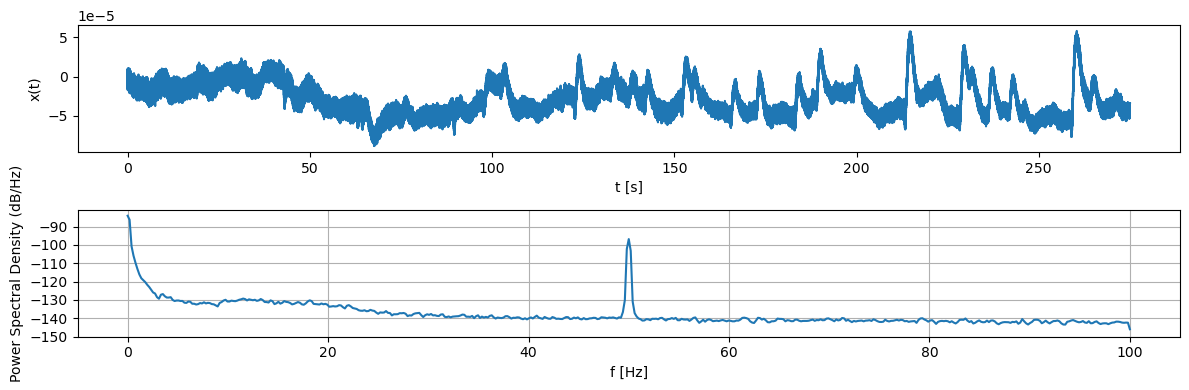

In [38]:
N = len(x_t)
t = torch.arange(0, N) * 1/fs

plt.figure(figsize=(12, 4))

plt.subplot(211)
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')

plt.subplot(212)
plt.psd(x_t, 1024, fs)
plt.xlabel('f [Hz]')

plt.tight_layout()
plt.show()

## delta

In [39]:
delta = bandpass_filter(eeg_data, 200, 1, 4)
delta.shape

Applying bandpass filter with freq_min 1 and freq_max 4...


torch.Size([230, 65, 55000])

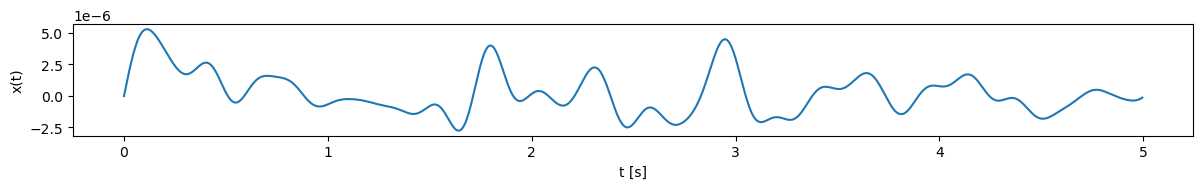

In [40]:
x_t = delta[subject][channel][:1000]
N = len(x_t)
t = torch.arange(0, N) * 1/fs
plt.figure(figsize=(12, 2))
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

## theta

In [41]:
theta = bandpass_filter(eeg_data, 200, 4, 8)
theta.shape

Applying bandpass filter with freq_min 4 and freq_max 8...


torch.Size([230, 65, 55000])

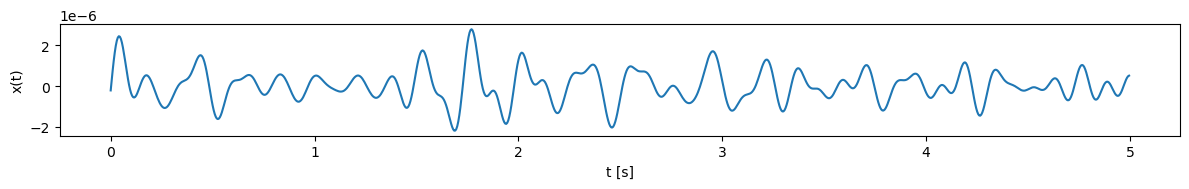

In [42]:
x_t = theta[subject][channel][:1000]
N = len(x_t)
t = torch.arange(0, N) * 1/fs
plt.figure(figsize=(12, 2))
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

## alpha

In [43]:
alpha = bandpass_filter(eeg_data, 200, 8, 12)
alpha.shape

Applying bandpass filter with freq_min 8 and freq_max 12...


torch.Size([230, 65, 55000])

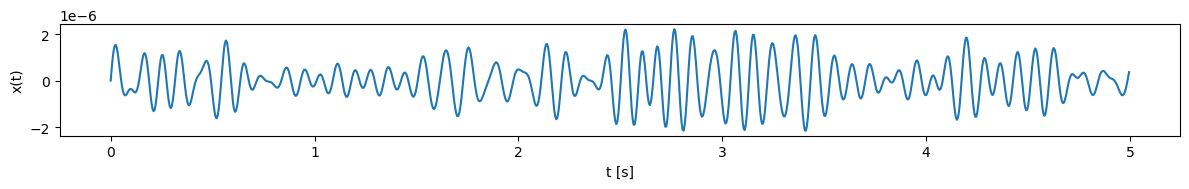

In [44]:
x_t = alpha[subject][channel][:1000]
N = len(x_t)
t = torch.arange(0, N) * 1/fs
plt.figure(figsize=(12, 2))
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

## beta

In [45]:
beta = bandpass_filter(eeg_data, 200, 12, 30)
beta.shape

Applying bandpass filter with freq_min 12 and freq_max 30...


torch.Size([230, 65, 55000])

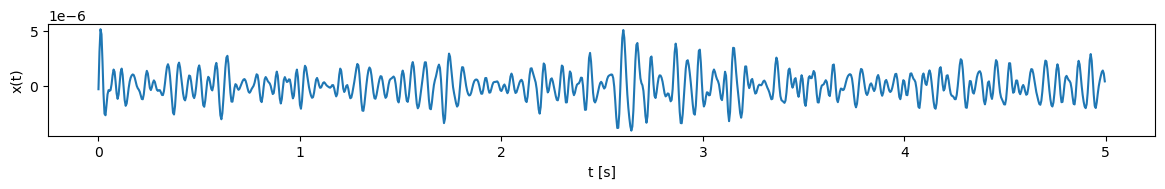

In [46]:
x_t = beta[subject][channel][:1000]
N = len(x_t)
t = torch.arange(0, N) * 1/fs
plt.figure(figsize=(12, 2))
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()

## gamma

In [47]:
def notch_filter(eeg_data, fs, notch_freq):
    """
    Remove the line noise frequency with a two-sided margin of 1Hz

    Parameters
    ----------
    eeg_data: [patients, channels, timepoints]
    fs: sampling frequency
    notch_freq: frequency where to apply the notch filter

    Returns
    -------
    EEG data with notch filter applied
    """
    print(f"Applying notch filter at frequency {notch_freq}...")
    N = eeg_data.shape[-1]
    Y = fft.fftshift(fft.fft(eeg_data, dim=-1), dim=-1)

    center = int(0.5 * N)
    offset = int(notch_freq * (N / fs))
    band = int(1 * (N / fs))

    Y[:, :, center - offset - band:center - offset + band] = 0
    Y[:, :, center + offset - band:center + offset + band] = 0

    eeg_data = fft.ifft(fft.ifftshift(Y, dim=-1), dim=-1)
    eeg_data = torch.real(eeg_data)

    return eeg_data

In [48]:
notched = notch_filter(eeg_data, fs=200, notch_freq=50)
gamma = bandpass_filter(notched, 200, 30, 99)
gamma.shape

Applying notch filter at frequency 50...
Applying bandpass filter with freq_min 30 and freq_max 99...


torch.Size([230, 65, 55000])

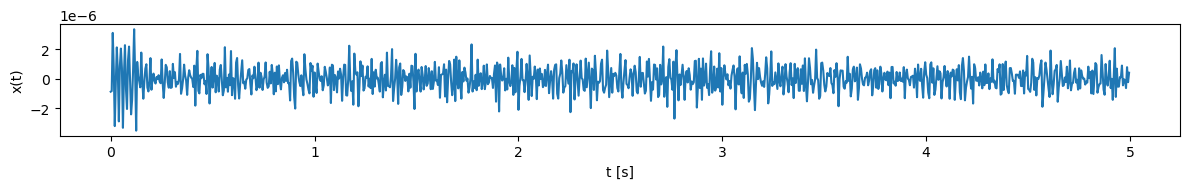

In [49]:
x_t = gamma[subject][channel][:1000]
N = len(x_t)
t = torch.arange(0, N) * 1/fs
plt.figure(figsize=(12, 2))
plt.plot(t, x_t)
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.tight_layout()
plt.show()